# VAR model with optimal lags

In [1]:
import pandas as pd
import numpy as np

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX

## Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

## Read the file

In [8]:
df = pd.read_csv('../Data/dataset_others.csv')
df = df.rename(columns={'F_Close_pred':'F_Close'})
# Extract _change_in_price columns
change_in_price_cols = [col for col in df.columns if '_change_in_price' in col]
df_change = df[change_in_price_cols].copy()

## 1-day forecast
We have found that 'JCI', 'TM' and '^IXIX' predict the trend with an accuracy of 1.0 and optimal lags are 2, 2, and 4, respectively.

In [11]:
df_JCI = df_change[['F_change_in_price', 'JCI_change_in_price']].copy()
df_JCI
train = df_JCI[:-5]
test = df_JCI[-5:]

In [13]:
train

,F_change_in_price,JCI_change_in_price
0,0.010000,0.330002
1,0.090000,0.160000
2,-0.040000,-0.279999
3,-0.050000,-0.560001
4,-0.120000,-0.480000
...,...,...
1227,-0.080000,-1.080002
1228,0.190000,-0.209999
1229,0.040000,0.860001
1230,0.030001,0.190002


In [14]:
test

,F_change_in_price,JCI_change_in_price
1232,0.230000,-0.529999
1233,-0.049999,-0.159996
1234,0.179999,0.379997
1235,-0.170000,-0.120003
1236,0.300000,0.990005


### JCI with optimal lags = 2

In [39]:
df_JCI = df_change[['F_change_in_price', 'JCI_change_in_price']].copy()
df_JCI
train_JCI = df_JCI[:-5]
test_JCI = df_JCI[-5:]
model_JCI = VAR(train_JCI)
results_JCI = model_JCI.fit(2)
lag_order_JCI = results_JCI.k_ar

In [40]:
train_JCI

,F_change_in_price,JCI_change_in_price
0,0.010000,0.330002
1,0.090000,0.160000
2,-0.040000,-0.279999
3,-0.050000,-0.560001
4,-0.120000,-0.480000
...,...,...
1227,-0.080000,-1.080002
1228,0.190000,-0.209999
1229,0.040000,0.860001
1230,0.030001,0.190002


In [53]:
forecast = pd.DataFrame(results_JCI.forecast(train_JCI.values, 
                                              steps=5), 
                           columns=train_JCI.columns, 
                           index=test_JCI.index)
#forecast_JCI
forecast_JCI = pd.concat([train_JCI, forecast], axis = 0, ignore_index=True)
forecast_JCI

,F_change_in_price,JCI_change_in_price
0,0.010000,0.330002
1,0.090000,0.160000
2,-0.040000,-0.279999
3,-0.050000,-0.560001
4,-0.120000,-0.480000
...,...,...
1232,-0.003182,0.014426
1233,-0.000569,0.065236
1234,0.001716,0.029560
1235,0.002409,0.027267


In [36]:
#forecast_JCI = pd.concat([train_JCI, results_JCI.forecast(train_JCI.values, 5)], axis = 1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [33]:
df_forecast_JCI = df[['Date', 'F_Close']].copy()
df_forecast_JCI['F_Close_Prediction'] = pd

,Date,F_Close
0,2019-11-26 00:00:00+00:00,9.01
1,2019-11-27 00:00:00+00:00,9.10
2,2019-11-29 00:00:00+00:00,9.06
3,2019-12-02 00:00:00+00:00,9.01
4,2019-12-03 00:00:00+00:00,8.89
...,...,...
1232,2024-10-22 00:00:00+00:00,11.11
1233,2024-10-23 00:00:00+00:00,11.06
1234,2024-10-24 00:00:00+00:00,11.24
1235,2024-10-25 00:00:00+00:00,11.07


In [ ]:
df_forecast['MoneyForecast'] = df['Money'].iloc[-test_obs-1] + df_forecast['Money1d'].cumsum()

In [18]:
#train

In [19]:
#test

In [4]:
[col for col in df.columns if 'F_' in col]

['F_Open',
 'F_Close',
 'F_High',
 'F_Low',
 'F_Volume',
 'F_Change',
 'F_Gain',
 'F_Loss',
 'F_Avg_Gain',
 'F_Avg_Loss',
 'F_SMA',
 'F_EMA',
 'F_change_in_price',
 'F_RSI',
 'F_k_percent',
 'F_r_percent',
 'F_MACD',
 'F_MACD_EMA',
 'F_ROC',
 'F_PVT',
 'F_Bollinger_Upper',
 'F_Bollinger_Lower']

## Timeseries forecast

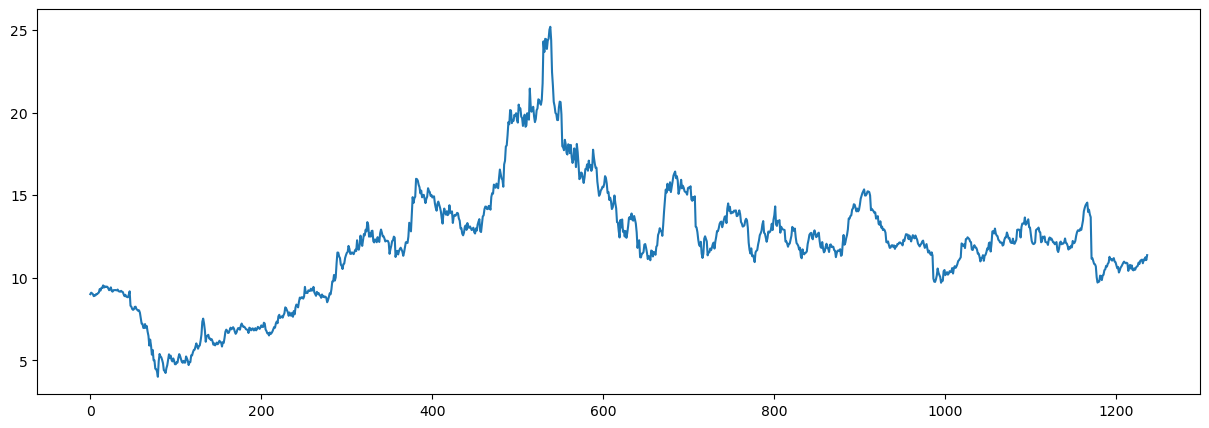

In [24]:
# Plot F time series
plt.figure(figsize=(15, 5))
plt.plot(df['F_Close'])
plt.show()

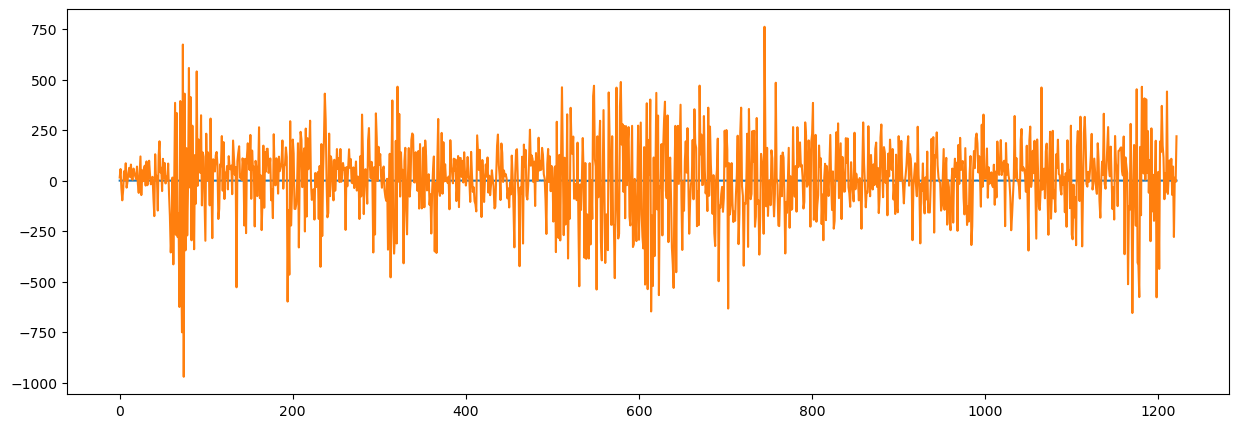

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(train)
plt.show()